In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
bc=pd.read_csv('Breast_cancer_data.csv')
#https://www.kaggle.com/merishnasuwal/breast-cancer-prediction-dataset
bc=bc[bc.isnull().any(axis=1)==False]

In [3]:
bc

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0
565,20.13,28.25,131.20,1261.0,0.09780,0
566,16.60,28.08,108.30,858.1,0.08455,0
567,20.60,29.33,140.10,1265.0,0.11780,0


In [4]:
X = bc.loc[:, bc.columns != 'diagnosis']
y = bc.loc[:, bc.columns == 'diagnosis']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True, stratify=y)

In [6]:
X_train

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness
405,10.94,18.59,70.39,370.0,0.10040
568,7.76,24.54,47.92,181.0,0.05263
99,14.42,19.77,94.48,642.5,0.09752
263,15.61,19.38,100.00,758.6,0.07840
420,11.57,19.04,74.20,409.7,0.08546
...,...,...,...,...,...
276,11.33,14.16,71.79,396.6,0.09379
429,12.72,17.67,80.98,501.3,0.07896
15,14.54,27.54,96.73,658.8,0.11390
497,12.47,17.31,80.45,480.1,0.08928


In [7]:
def learning_curves(clf):
    train_sizes, train_scores, validation_scores, fit_time, _ = learning_curve(clf, X_train, y_train.values.ravel(), 
    train_sizes =np.linspace(0.3,0.9,7),cv = 5, scoring = 'roc_auc', n_jobs=1, return_times=True)
    
    train_scores_mean = train_scores.mean(axis = 1)
    train_scores_std=train_scores.std(axis=1)
    validation_scores_mean = validation_scores.mean(axis = 1)
    validation_scores_std= validation_scores.std(axis=1)
    fit_time_mean = fit_time.mean(axis=1)
    fit_time_std = fit_time.std(axis=1)
    
    # Time VS Train Sizes
    plt.plot(train_sizes, fit_time_mean, color='red', marker='o')
    plt.fill_between(train_sizes, fit_time_mean + fit_time_std, fit_time_mean - fit_time_std, alpha=0.15, color='red')
    plt.xlabel('Training Set Size')
    plt.ylabel('Time')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.show()
    
    # ROC AUC VS Train Sizes
    plt.plot(train_sizes, train_scores_mean, color='red', marker='o', label='Training ROC AUC')
    plt.fill_between(train_sizes, train_scores_mean + train_scores_std, train_scores_mean - train_scores_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, validation_scores_mean, color='green', marker='+', linestyle='--', label='Validation ROC AUC')
    plt.fill_between(train_sizes, validation_scores_mean + validation_scores_std, validation_scores_mean - validation_scores_std, alpha=0.15, color='green')
    plt.xlabel('Training Data Size')
    plt.ylabel('ROC AUC Score')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.show()



In [8]:
def Cross_Validation(clf, parameters, X, y):
    model = RandomizedSearchCV(clf, parameters, scoring='roc_auc', n_jobs=-1, verbose=1, n_iter=5, refit=True,
                                  cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True))
    
    model.fit(X, y.values.ravel())
    
    return model.best_estimator_

In [9]:
def tune_decisionTree(X_train, y_train, X_test):
    tree = DecisionTreeClassifier()
    parameters = {"max_features": [2, 3, 4, 5],
                  "criterion": ["gini", "entropy"],
              "min_samples_leaf": [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35]}

    best_tree_model = Cross_Validation(tree, parameters, X_train, y_train)
    print('Best Tuned Model: ', best_tree_model)
    y_pred = best_tree_model.predict(X_test)
    y_prob = best_tree_model.predict_proba(X_test)[:,1]
    
    return y_pred, y_prob, best_tree_model

In [10]:
def tune_gboost(X_train, y_train, X_test):
    gboost = GradientBoostingClassifier()
    parameters = {"max_depth": [3,5,7,9,11,13,15,17,19],
              "learning_rate": [1, 0.5, 0.25, 0.1, 0.05, 0.01, 0.001],
              "n_estimators": [5, 25, 50, 75, 100, 125, 150, 175, 200]}

    best_gboost_model = Cross_Validation(gboost, parameters, X_train, y_train)
    print('Best Tuned Model: ',best_gboost_model)
    y_pred = best_gboost_model.predict(X_test)
    y_prob = best_gboost_model.predict_proba(X_test)[:,1]
    
    return y_pred, y_prob, best_gboost_model

In [11]:
def tune_svm(X_train, y_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    svm = SVC(probability=True)
    parameters = {"C":  [0.001, 0.01, 0.1, 1, 10,50, 100],
                    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
    best_svm_model = Cross_Validation(svm, parameters, X_train, y_train)
    print(best_svm_model)
    y_pred = best_svm_model.predict(X_test)
    y_prob = best_svm_model.predict_proba(X_test)[:,1]
    return y_pred, y_prob, best_svm_model

In [12]:
def tune_knn(X_train, y_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    knn = KNeighborsClassifier()
    parameters = {'n_neighbors':list(range(1,50)), 'weights':['uniform', 'distance']}
    best_knn_model = Cross_Validation(knn, parameters, X_train, y_train)
    print(best_knn_model)
    y_pred = best_knn_model.predict(X_test)
    y_prob = best_knn_model.predict_proba(X_test)[:,1]
    return y_pred, y_prob, best_knn_model

In [13]:
def show_performance_metrics(clfname, y_pred, y_test, y_prob):
    accuracy = accuracy_score(y_pred, y_test)
    precision = precision_score(y_pred, y_test)
    recall = recall_score(y_pred, y_test)
    f1score = f1_score(y_pred, y_test)
    roc_auc_score=sklearn.metrics.roc_auc_score(y_test, y_prob)
    print(clfname)
    print(("Accuracy: "+str(accuracy)))
    print(("Precision: "+str(precision)))
    print(("Recall: "+str(recall)))
    print(("F1-score: "+str(f1score)))
    print('ROC AUC Score: '+str(roc_auc_score))

## Decision tree

### Tune Parameter

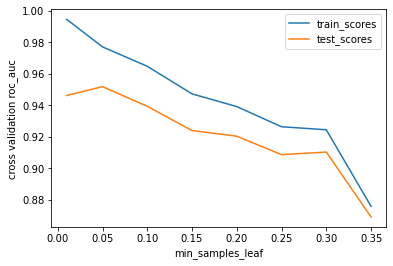

In [14]:
train_scores=[]
test_scores=[]
min_samples_leaf=[0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35]
for i in min_samples_leaf:
    tree = DecisionTreeClassifier(min_samples_leaf=i)
    cv_results = cross_validate(tree, X_train, y_train.values.ravel(), cv=5, scoring='roc_auc', return_train_score=True)
    train_scores.append(cv_results['train_score'].mean())
    test_scores.append(cv_results['test_score'].mean())
plt.plot(min_samples_leaf,train_scores,label='train_scores')
plt.plot(min_samples_leaf,test_scores,label='test_scores')
plt.xlabel('min_samples_leaf')
plt.ylabel('cross validation roc_auc')
plt.legend()
plt.show()

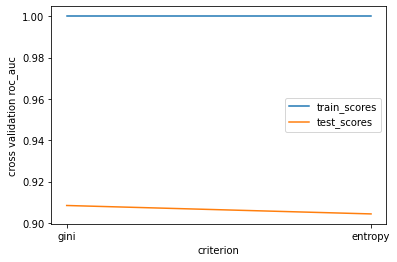

In [15]:
train_scores=[]
test_scores=[]
criterion = ["gini", "entropy"]
for i in criterion:
    tree = DecisionTreeClassifier(criterion=i)
    cv_results = cross_validate(tree, X_train, y_train.values.ravel(), cv=5, scoring='roc_auc', return_train_score=True)
    train_scores.append(cv_results['train_score'].mean())
    test_scores.append(cv_results['test_score'].mean())
plt.plot(criterion,train_scores,label='train_scores')
plt.plot(criterion,test_scores,label='test_scores')
plt.xlabel('criterion')
plt.ylabel('cross validation roc_auc')
plt.legend()
plt.show()

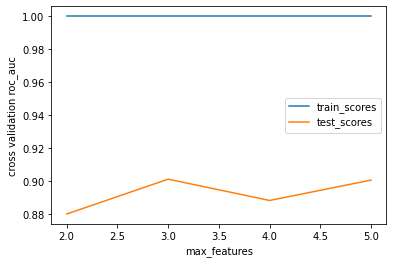

In [20]:
train_scores=[]
test_scores=[]
max_features = [2, 3, 4, 5]
for i in max_features:
    tree = DecisionTreeClassifier(max_features = i)
    cv_results = cross_validate(tree, X_train, y_train.values.ravel(), cv=5, scoring='roc_auc', return_train_score=True)
    train_scores.append(cv_results['train_score'].mean())
    test_scores.append(cv_results['test_score'].mean())
plt.plot(max_features,train_scores,label='train_scores')
plt.plot(max_features,test_scores,label='test_scores')
plt.xlabel('max_features')
plt.ylabel('cross validation roc_auc')
plt.legend()
plt.show()

### Find best model and plot learning curve

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.5s finished


Best Tuned Model:  DecisionTreeClassifier(criterion='entropy', max_features=4,
                       min_samples_leaf=0.01)
Decision Tree
Accuracy: 0.9210526315789473
Precision: 0.9444444444444444
Recall: 0.9315068493150684
F1-score: 0.9379310344827586
ROC AUC Score: 0.9396494708994709


No handles with labels found to put in legend.


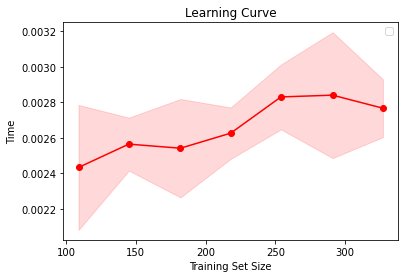

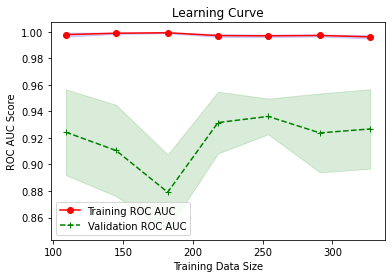

In [17]:
# Find Best Tree
y_pred,y_prob,best_model = tune_decisionTree(X_train,y_train,X_test)
show_performance_metrics("Decision Tree",y_pred,y_test, y_prob)
#Plot Learning Curve
learning_curves(best_model)

## Gradient Boosting

### Tune Parameter

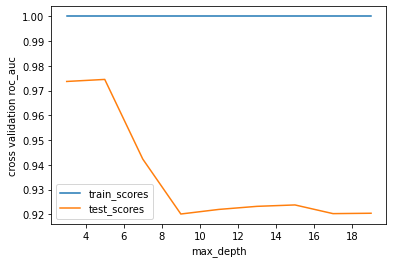

In [21]:
train_scores=[]
test_scores=[]
maxdepth=[3,5,7,9,11,13,15,17,19]
for i in maxdepth:
    gradientboost = GradientBoostingClassifier(max_depth=i)
    cv_results = cross_validate(gradientboost, X_train, y_train.values.ravel(), cv=5, scoring='roc_auc', return_train_score=True)
    train_scores.append(cv_results['train_score'].mean())
    test_scores.append(cv_results['test_score'].mean())

plt.plot(maxdepth,train_scores,label='train_scores')
plt.plot(maxdepth,test_scores,label='test_scores')
plt.xlabel('max_depth')
plt.ylabel('cross validation roc_auc')
plt.legend()
plt.show()

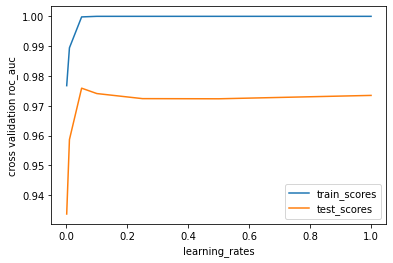

In [22]:
train_scores=[]
test_scores=[]
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01, 0.001]
for i in learning_rates:
    gradientboost = GradientBoostingClassifier(learning_rate=i)
    cv_results = cross_validate(gradientboost, X_train, y_train.values.ravel(), cv=5, scoring='roc_auc', return_train_score=True)
    train_scores.append(cv_results['train_score'].mean())
    test_scores.append(cv_results['test_score'].mean())

plt.plot(learning_rates,train_scores,label='train_scores')
plt.plot(learning_rates,test_scores,label='test_scores')
plt.xlabel('learning_rates')
plt.ylabel('cross validation roc_auc')
plt.legend()
plt.show()

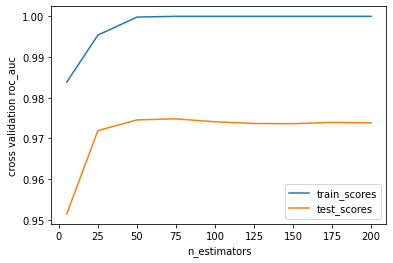

In [23]:
train_scores=[]
test_scores=[]
n_estimators = [5, 25, 50, 75, 100, 125, 150, 175, 200]
for i in n_estimators:
    gradientboost = GradientBoostingClassifier(n_estimators=i)
    cv_results = cross_validate(gradientboost, X_train, y_train.values.ravel(), cv=5, scoring='roc_auc', return_train_score=True)
    train_scores.append(cv_results['train_score'].mean())
    test_scores.append(cv_results['test_score'].mean())

plt.plot(n_estimators,train_scores,label='train_scores')
plt.plot(n_estimators,test_scores,label='test_scores')
plt.xlabel('n_estimators')
plt.ylabel('cross validation roc_auc')
plt.legend()
plt.show()

### Find best model and plot learning curve

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.5s finished


Best Tuned Model:  GradientBoostingClassifier(learning_rate=0.25, n_estimators=200)
Gradient Boosting
Accuracy: 0.9298245614035088
Precision: 0.9583333333333334
Recall: 0.9324324324324325
F1-score: 0.9452054794520548
ROC AUC Score: 0.9778439153439152


No handles with labels found to put in legend.


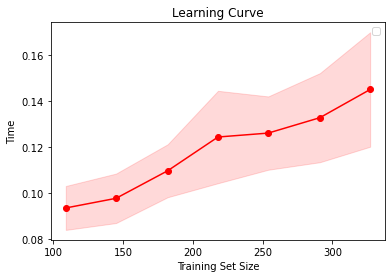

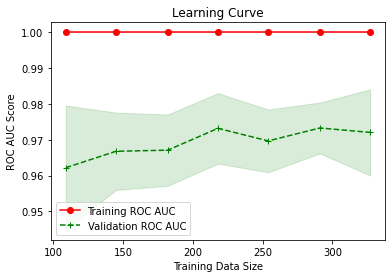

In [24]:
# Find Best Tree
y_pred,y_prob,best_model = tune_gboost(X_train,y_train,X_test)
show_performance_metrics("Gradient Boosting",y_pred,y_test, y_prob)
#Plot Learning Curve
learning_curves(best_model)

## SVM

### Tune Parameter

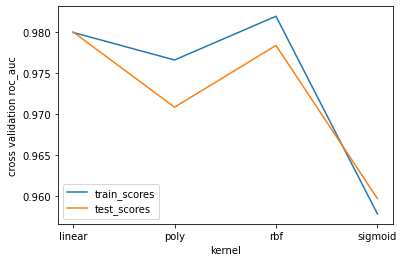

In [14]:
train_scores=[]
test_scores=[]
scaler = StandardScaler()
transformed_X=scaler.fit_transform(X_train)
kernel=['linear', 'poly', 'rbf', 'sigmoid']
for i in kernel:
    svm = SVC(kernel=i)
    cv_results = cross_validate(svm, transformed_X, y_train.values.ravel(), cv=5, scoring='roc_auc', return_train_score=True)
    train_scores.append(cv_results['train_score'].mean())
    test_scores.append(cv_results['test_score'].mean())
plt.plot(kernel,train_scores,label='train_scores')
plt.plot(kernel,test_scores,label='test_scores')
plt.xlabel('kernel')
plt.ylabel('cross validation roc_auc')
plt.legend()
plt.show()

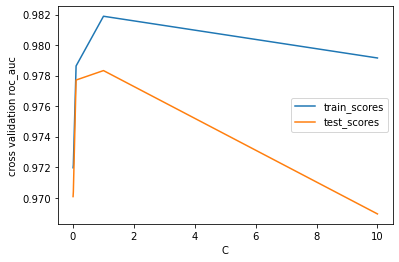

In [17]:
train_scores=[]
test_scores=[]
scaler = StandardScaler()
transformed_X=scaler.fit_transform(X_train)
C = [0.001, 0.01, 0.1, 1,10]
for i in C:
    svm = SVC(C=i)
    cv_results = cross_validate(svm, transformed_X, y_train.values.ravel(), cv=5, scoring='roc_auc', return_train_score=True)
    train_scores.append(cv_results['train_score'].mean())
    test_scores.append(cv_results['test_score'].mean())
plt.plot(C,train_scores,label='train_scores')
plt.plot(C,test_scores,label='test_scores')
plt.xlabel('C')
plt.ylabel('cross validation roc_auc')
plt.legend()
plt.show()

### Find best model and plot learning curve

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.3s finished


SVC(C=0.1, kernel='linear', probability=True)
SVM
Accuracy: 0.9298245614035088
Precision: 0.9722222222222222
Recall: 0.9210526315789473
F1-score: 0.9459459459459458
ROC AUC Score: 0.9904100529100529


No handles with labels found to put in legend.


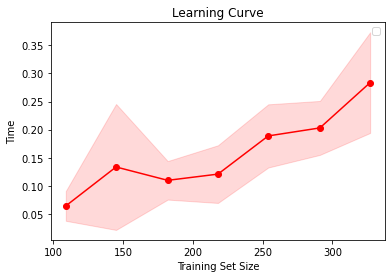

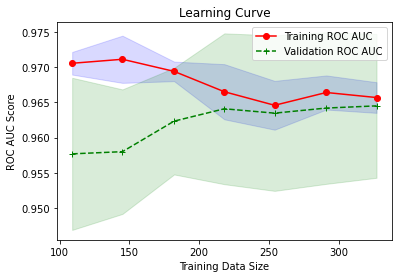

In [16]:
# Find Best Tree
y_pred,y_prob,best_model = tune_svm(X_train,y_train,X_test)
show_performance_metrics("SVM",y_pred,y_test, y_prob)
#Plot Learning Curve
learning_curves(best_model)

## KNN

### Tune Parameter

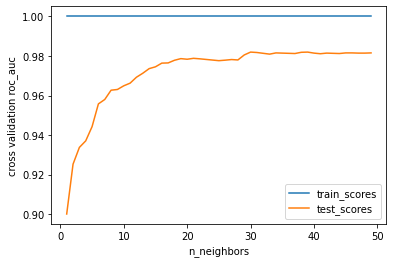

In [18]:
scaler = StandardScaler()
transformed_X=scaler.fit_transform(X_train)
train_scores=[]
test_scores=[]
n_neighbors=range(1, 50)
for i in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    cv_results = cross_validate(knn, transformed_X, y_train.values.ravel(), cv=5, scoring='roc_auc', return_train_score=True)
    train_scores.append(cv_results['train_score'].mean())
    test_scores.append(cv_results['test_score'].mean())
plt.plot(n_neighbors,train_scores,label='train_scores')
plt.plot(n_neighbors,test_scores,label='test_scores')
plt.xlabel('n_neighbors')
plt.ylabel('cross validation roc_auc')
plt.legend()

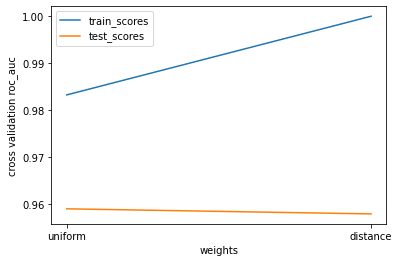

In [19]:
scaler = StandardScaler()
transformed_X=scaler.fit_transform(X_train)
train_scores=[]
test_scores=[]
weights=['uniform', 'distance']
for i in weights:
    knn = KNeighborsClassifier(n_neighbors=7, weights=i)
    cv_results = cross_validate(knn, transformed_X, y_train.values.ravel(), cv=5, scoring='roc_auc', return_train_score=True)
    train_scores.append(cv_results['train_score'].mean())
    test_scores.append(cv_results['test_score'].mean())
plt.plot(weights,train_scores,label='train_scores')
plt.plot(weights,test_scores,label='test_scores')
plt.xlabel('weights')
plt.ylabel('cross validation roc_auc')
plt.legend()

### Find best model and plot learning curve

Fitting 5 folds for each of 5 candidates, totalling 25 fits
KNeighborsClassifier(n_neighbors=33)
KNN
Accuracy: 0.9298245614035088
Precision: 0.9722222222222222
Recall: 0.9210526315789473
F1-score: 0.9459459459459458
ROC AUC Score: 0.9875992063492064


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished
No handles with labels found to put in legend.


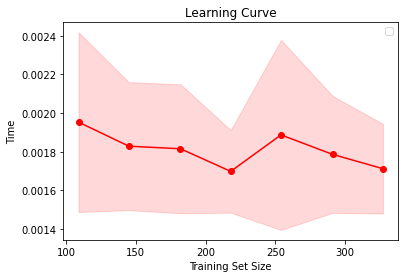

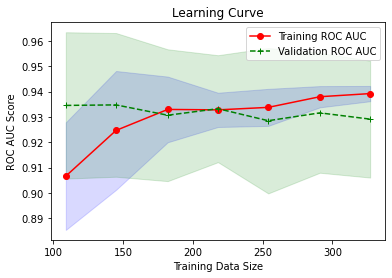

In [20]:
# Find Best Tree
y_pred,y_prob,best_model = tune_knn(X_train,y_train,X_test)
show_performance_metrics("KNN",y_pred,y_test, y_prob)
#Plot Learning Curve
learning_curves(best_model)

## Neural Network

### Tune Parameter

In [21]:
train_scores=[]
test_scores=[]
optimizers=['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
for i in optimizers:
    def create_model(optimizer=i):
        # create model
        model = Sequential()
        model.add(Dense(15, input_dim=5, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        # Compile model
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model

    np.random.seed(13)
    # create model
    model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
    # define the grid search parameters

    cv_results = cross_validate(model, X_train, y_train.values.ravel(), cv=5, error_score="raise", scoring='accuracy', return_train_score=True)
    #print(cv_results)

    train_scores.append(cv_results['train_score'].mean())
    test_scores.append(cv_results['test_score'].mean())

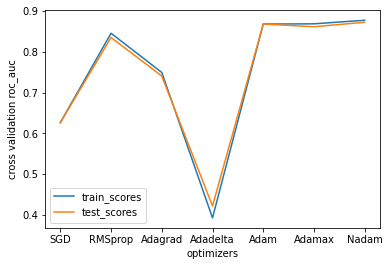

In [22]:
plt.plot(optimizers,train_scores,label='train_scores')
plt.plot(optimizers,test_scores,label='test_scores')
plt.xlabel('optimizers')
plt.ylabel('cross validation roc_auc')
plt.legend()

In [28]:
train_scores=[]
test_scores=[]
epochs = list(range(10,150,30))
for i in epochs:
    def create_model(optimizer='adam'):
        # create model
        model = Sequential()
        model.add(Dense(15, input_dim=5, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        # Compile model
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model

    np.random.seed(13)
    # create model
    model = KerasClassifier(build_fn=create_model, epochs=i, batch_size=10, verbose=0)
    # define the grid search parameters

    cv_results = cross_validate(model, X_train, y_train.values.ravel(), cv=5, error_score="raise", scoring='accuracy', return_train_score=True)
    #print(cv_results)

    train_scores.append(cv_results['train_score'].mean())
    test_scores.append(cv_results['test_score'].mean())

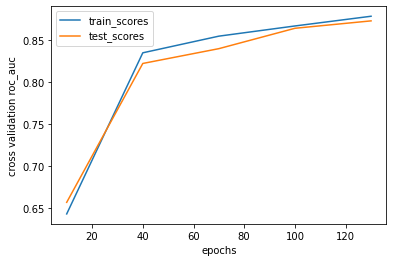

In [29]:
plt.plot(epochs,train_scores,label='train_scores')
plt.plot(epochs,test_scores,label='test_scores')
plt.xlabel('epochs')
plt.ylabel('cross validation roc_auc')
plt.legend()

In [25]:
train_scores=[]
test_scores=[]
batch_sizes = list(range(10,150,10))
for i in batch_sizes:
    def create_model(optimizer='adam'):
        # create model
        model = Sequential()
        model.add(Dense(15, input_dim=5, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        # Compile model
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model

    np.random.seed(13)
    # create model
    model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=i, verbose=0)
    # define the grid search parameters

    cv_results = cross_validate(model, X_train, y_train.values.ravel(), cv=5, error_score="raise", scoring='accuracy', return_train_score=True)
    #print(cv_results)

    train_scores.append(cv_results['train_score'].mean())
    test_scores.append(cv_results['test_score'].mean())

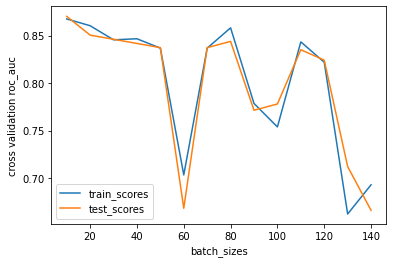

In [26]:
plt.plot(batch_sizes,train_scores,label='train_scores')
plt.plot(batch_sizes,test_scores,label='test_scores')
plt.xlabel('batch_sizes')
plt.ylabel('cross validation roc_auc')
plt.legend()

### Find best model and plot learning curve

Neural Network
Accuracy: 0.8771929824561403
Precision: 0.9722222222222222
Recall: 0.8536585365853658
F1-score: 0.9090909090909091
ROC AUC Score: 0.9143518518518519


No handles with labels found to put in legend.


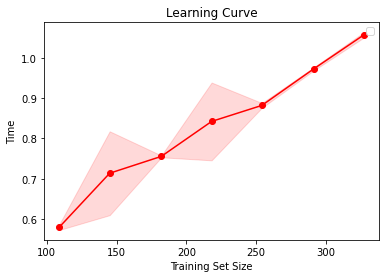

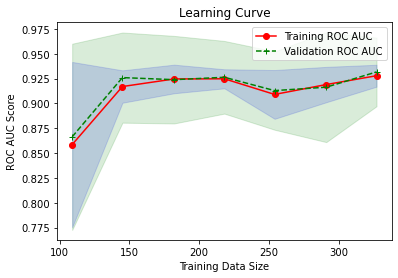

In [27]:
def create_model(optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(15, input_dim=5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# create model
best_nn_model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=20, verbose=0)
print(best_nn_model)
best_nn_model.fit(X_train, y_train.values.ravel())
y_pred = best_nn_model.predict(X_test)
y_prob = best_nn_model.predict_proba(X_test)[:,1] 


show_performance_metrics("Neural Network",y_pred,y_test, y_prob)
#Plot Learning Curve
learning_curves(best_nn_model)